In [1]:
%reset -fs

In [47]:
import pandas as pd
import numpy as np
import string
import re
import spacy
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
from matplotlib import pyplot as plt
import joblib
from dask.distributed import Client

%matplotlib inline

In [ ]:
client = Client(processes=False)


In [3]:
stop_words = text.ENGLISH_STOP_WORDS.union(['nof', 'nthe', 'nand', 'nto', 'nin', 'nit', 'nfor', 'na', 'nthat', 'nbe', 'applause', 'nwhich', 'nis', 'nare', 'ni', 'nnot', 'nby', 'nhave', 'nbut', 'nwe', 'nwith', 'nfrom', 'nwill', 'nhas', 'nan', 'nif', 'nour'])

In [4]:
df = pd.read_csv('sotu_texts.csv')
df

,President,Year,Title,Text
0,George Washington,1790,First State of the Union Address,['I embrace with great satisfaction the opport...
1,George Washington,1790,Second State of the Union Address,['Fellow-Citizens of the Senate and the House ...
2,George Washington,1791,Third State of the Union Address,['Fellow-Citizens of the Senate and the House ...
3,George Washington,1792,Fourth State of the Union Address,['Fellow-Citizens of the Senate and of the Hou...
4,George Washington,1793,Fifth State of the Union Address,['Fellow Citizens of the Senate and of the Hou...
...,...,...,...,...
215,Barack Obama,2016,Barack Obama's Eighth State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ..."
216,Donald Trump,2017,Donald Trump's First State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ..."
217,Donald Trump,2018,Donald Trump's Second State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ..."
218,Donald Trump,2019,Donald Trump's Third State of the Union Address,"['Madam Speaker, Mr. Vice President, Members o..."


In [5]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

df['Text'] = df.Text.map(alphanumeric).map(punc_lower)

In [6]:
nlp = spacy.load("en_core_web_sm")
docs = nlp.pipe(df.Text)

In [7]:
docs_clean = [[w.lemma_.lower() for w in doc if (not w.is_stop and not w.is_punct and not w.like_num)] for doc in docs]
df['docs_clean'] = docs_clean

In [8]:
docs_list_clean = [' '.join(doc) for doc in docs_clean]


In [9]:
count_vec = CountVectorizer(stop_words=stop_words, ngram_range=(1,3), min_df=1, max_df=220)
X = count_vec.fit_transform(docs_list_clean)

In [10]:
num_topics = 10
topics = TruncatedSVD(num_topics)
doc_topic = topics.fit_transform(X)

In [11]:
topic_word = pd.DataFrame(topics.components_.round(3),
             columns = count_vec.get_feature_names_out())

In [12]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [13]:
display_topics(topics, count_vec.get_feature_names_out(), 10)


Topic  0
government, year, congress, united, states, united states, country, state, great, law

Topic  1
program, year, world, new, work, need, help, nation, america, federal

Topic  2
program, dollar, year, fiscal, united, fiscal year, war, expenditure, states, united states

Topic  3
man, dollar, law, business, service, department, court, legislation, national, expenditure

Topic  4
administration, energy, policy, states, effort, provide, united states, international, development, area

Topic  5
year, american, america, work, report, department, secretary, tonight, job, united states

Topic  6
mexico, war, united, united states, states, american, texas, peace, mexican, army

Topic  7
department, mexico, american, government, court, congress, canal, tariff, bank, foreign

Topic  8
mexico, country, texas, public, mexican, year, land, law, increase, work

Topic  9
world, free, great, nation, peace, communist, present, defense, war, measure


In [14]:
tfidf_vec = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3), min_df=1, max_df=220)
X = tfidf_vec.fit_transform(docs_list_clean)

In [15]:
doc_topic = topics.fit_transform(X)

In [16]:
display_topics(topics, tfidf_vec.get_feature_names_out(), 10)


Topic  0
government, year, congress, united, states, united states, country, people, great, state

Topic  1
america, job, tonight, help, world, program, americans, year, new, people

Topic  2
program, economic, federal, world, problem, national, increase, nation, development, need

Topic  3
nation, world, war, program, peace, soviet, object, state, union, united

Topic  4
man, great, interstate, law, corporation, commerce, war, good, interstate commerce, public

Topic  5
world, war, soviet, united, fight, free, man, states, united states, united nations

Topic  6
state, constitution, mexico, people, war, texas, union, kansas, president, shall

Topic  7
iraq, terrorist, mexico, iraqi, terror, government, america, al, regime, saddam

Topic  8
bank, public, world, country, silver, debt, gold, measure, free, treasury

Topic  9
vietnam, democracy, congress, people, child, government, america, nation, help, state


In [17]:
topics = LatentDirichletAllocation(n_components=num_topics, )

In [18]:
X = count_vec.fit_transform(docs_list_clean)

In [19]:
doc_topic = topics.fit_transform(X)

In [20]:
display_topics(topics, count_vec.get_feature_names_out(), 10)


Topic  0
century, social security, save social, save social security, saddam, community, iraq, leadership, historic responsibility, century america

Topic  1
government, country, law, year, great, public, congress, increase, man, people

Topic  2
government, states, united, united states, congress, state, country, year, great, public

Topic  3
year, people, work, nation, government, new, american, war, world, congress

Topic  4
government, year, congress, united, states, united states, country, great, state, law

Topic  5
state, constitution, legislature, slave, union, specific, election, specific duty, constitutional, sovereign

Topic  6
bank, credit, emergency, competitive, past year, decrease, bond, depression, board, railway

Topic  7
america, world, new, people, year, american, nation, great, americans, tonight

Topic  8
year, government, congress, people, united, nation, country, states, united states, world

Topic  9
government, year, people, country, great, american, congress,

In [21]:
X = tfidf_vec.fit_transform(docs_list_clean)

In [22]:
doc_topic = topics.fit_transform(X)

In [23]:
display_topics(topics, tfidf_vec.get_feature_names_out(), 10)


Topic  0
government, year, congress, united, people, states, country, united states, great, nation

Topic  1
public investigation, viet nam, nam, viet, employment budget, let share, situation europe, cairo teheran, mr hull, nuclear defense

Topic  2
crude oil, markwell, surplus capacity, powerplant, send great, war send great, send great britain, prisoner war send, railway manager, growth federal

Topic  3
ukrainian, covid, putin, axis, south vietnam, great society, hat, reconstruction finance corporation, reconstruction finance, ukrainian people

Topic  4
isil, megan, ryan, jamiel, obamacare, term plan, oliver, susan, jenna, dollar overseas

Topic  5
industrial recovery, hard work freedom, work freedom, private employment, industrial recovery act, national industrial recovery, national industrial, dollar nation, religion democracy, alien enemy

Topic  6
autocracy, decree france, suspension embargo, policy good neighbor, soviet troop, policy good, selfish power, true today, north atla

In [24]:
doc_word = count_vec.fit_transform(docs_list_clean)
words = list(np.asarray(count_vec.get_feature_names_out()))

In [25]:
topic_model = ct.Corex(n_hidden=10, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=docs_list_clean, anchors=[['economy', 'job', 'work', 'program', 'employment'], ['manufacturing', 'production', 'build', 'commerce', 'business', 'farmer', 'agriculture', 'crop', 'private business', 'farm', 'land'], ['government', 'america', 'american', 'people', 'constitution', 'country', 'congress', 'united', 'states', 'people', 'nation', 'federal', 'state'], ['money', 'expenditure', 'tax', 'fiscal', 'treasury', 'stimulus', 'income', 'dollar', 'currency', 'tariff', 'debt', 'cent', 'bank', 'home'], ['protest', 'race', 'movement', 'strike', 'black', 'indian', 'latino', 'slave', 'civil','right','liberty', 'immigration', 'mexico', 'dreamer', 'citizenship'], ['germany', 'france', 'spain', 'nato', 'europe', 'hitler', 'japan', 'japanese', 'nazi', 'putin', 'ukraine', 'korea', 'soviet', 'ukraine', 'british', 'cuba', 'venezuela', 'iran', 'china', 'russia', 'canada', 'war', 'fight', 'vietnam', 'alliance', 'adversary', 'enemy', 'international', 'german', 'navy', 'military', 'troop', 'sea power', 'admiral', 'general', 'iraqi', 'iraq', 'insurgent', 'terrorist', 'saddam', 'kuwait', 'syria', 'israel', 'panama', 'army', 'peace', 'afghanistan', 'al qaeda', 'taliban', 'islamic', 'defense', 'treaty'], ['energy', 'atomic', 'renewable', 'oil', 'research', 'science', 'innovation', 'cyber', 'space', 'moon', 'rocket', 'cancer', 'health', 'industrial', 'covid', 'pandemic'], ['law', 'order', 'court', 'crime', 'gang', 'police', 'safe', 'gun', 'sedition', 'communist', 'communism'], ['legislation', 'congress', 'action', 'service', 'provide'], ['people', 'great', 'new', 'opportunity', 'providence', 'sacrifice', 'favor', 'fate', 'purpose', 'hardship', 'endure', 'overcome']], anchor_strength=2)

In [26]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: program,job,budget,goal,today,economic,economy,help,speaker,basic
1: agriculture,crop,production,reduction,farm,farmer,business,recommendation,organization,agricultural
2: federal,america,suspicion,turkey,battle,thrift,people,grave,enlist,federal jurisdiction
3: cent,fiscal,currency,tariff,treasury,judgment,confer,national bank,commend,suggestion
4: protest,mexico,civil,american citizen,equity,movement,impossible,frequently,march,central
5: china,troop,russia,passenger,meridian,work department,position united states,position united,panama,litigation
6: money spend,cancer,raise minimum,clean energy,raise minimum wage,research,friendly relation country,detect,work hand,oil
7: police,gun,soul,break,gang,uranium,trap,state act,fighting,daring
8: legislation,action,available,large,needful,responsibility,productive capacity,possible,irritation,assume
9: public land,favor,north,successful,washington,attributable,separate,admit,opportunity,prove


In [50]:
predictions = pd.DataFrame(topic_model.log_p_y_given_x, columns=['topic'+str(i) for i in range(10)])
predictions

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,-4154.626053,-741.373215,-421.404408,-4755.323743,-8363.257236,-1956.191807,-188.021688,-653.499084,-373.289886,-1398.062571
1,-5248.441580,-738.821442,-434.990948,-4729.211617,-8351.076316,-1940.667574,-159.300166,-659.276767,-380.433264,-1375.232822
2,-8716.290278,-771.581917,-480.548199,-4628.843038,-8344.027847,-1961.058730,-316.700289,-754.483079,-404.151471,-1323.670827
3,-7842.563055,-749.249114,-473.345939,-4678.868381,-8302.944617,-1957.891061,-310.216482,-744.921538,-413.681256,-1397.785204
4,-803.169950,-779.991293,0.000000,-4668.374906,-8317.655350,-1945.777918,0.000000,-721.079665,-397.458738,-1318.185730
...,...,...,...,...,...,...,...,...,...,...
215,0.000000,-801.838442,0.000000,-4687.851906,-8315.092543,0.000000,0.000000,0.000000,-390.867997,-1359.446966
216,0.000000,-849.211107,0.000000,-4653.597713,0.000000,0.000000,-203.298360,0.000000,0.000000,-1357.686847
217,0.000000,-821.942005,-397.764586,-4650.762223,-8331.899758,-1949.774242,-411.497171,0.000000,-354.395220,0.000000
218,0.000000,-831.811356,0.000000,-4650.933497,-8315.360127,0.000000,0.000000,0.000000,-418.724612,-1339.472366


In [28]:
vt.vis_rep(topic_model, column_label=words, prefix='topic-model-example')

Print topics in text file


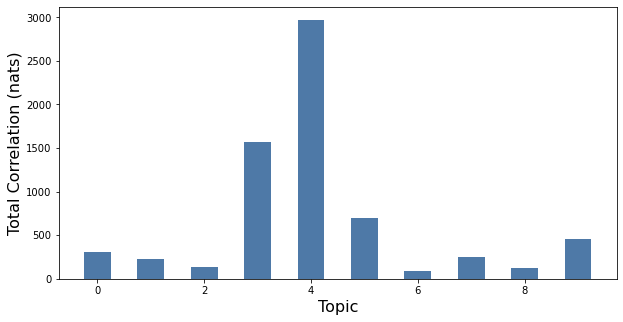

In [48]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
plt.savefig('topic_graph.png')

In [52]:
topic_model2 = ct.Corex(n_hidden=10, words=words, seed=2)
topic_model2.fit(doc_word, words=words, docs=docs_list_clean)

KeyboardInterrupt: 